# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [253]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [254]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [255]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [256]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise) # Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [257]:
from sklearn.metrics import mean_squared_error
err = []
LRs = []

for N in N_grid:
    LR = lm.LinearRegression()
    rand = np.random.randint(0,990, size= N)
    LR.fit(X[rand],y[rand])
    y_pred = LR.predict(X)
    err.append(mean_squared_error(y_pred,y_gt))
    LRs.append(LR)


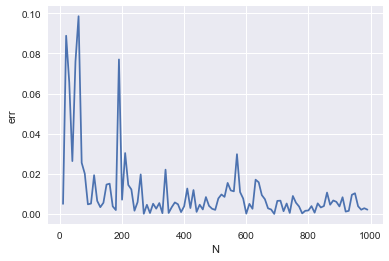

In [258]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

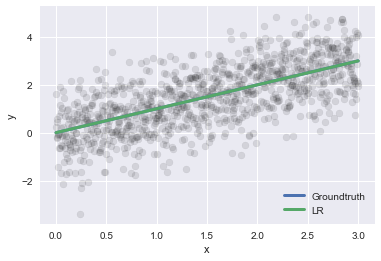

In [259]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Проделайте тоже самое для KNN при n_neighbors=3.

In [260]:
from sklearn.neighbors import KNeighborsRegressor

err = []
KNNs = []

for N in N_grid:
    clf= KNeighborsRegressor(n_neighbors=3)
    rand = np.random.randint(0,990, size= N)
    clf.fit(X[rand],y[rand])
    y_pred = clf.predict(X)
    err.append(mean_squared_error(y_pred,y_gt))
    KNNs.append(clf)

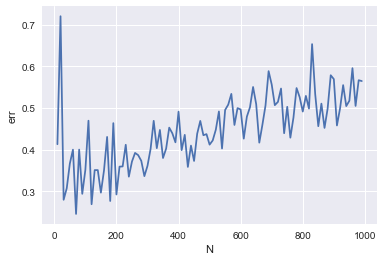

In [261]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

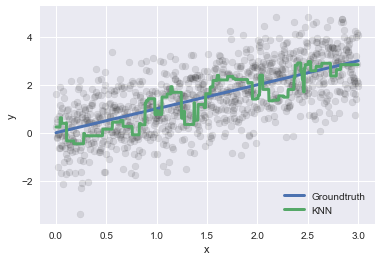

In [262]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличте число соседей до 10 и проделайте тоже самое.

In [263]:
err = []
KNNs = []

for N in N_grid:
    clf= KNeighborsRegressor(n_neighbors=10)
    rand = np.random.randint(0,990, size= N)
    clf.fit(X[rand],y[rand])
    y_pred = clf.predict(X)
    err.append(mean_squared_error(y_pred,y_gt))
    KNNs.append(clf)

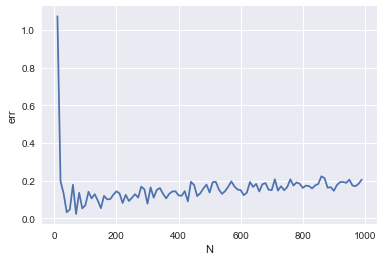

In [264]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

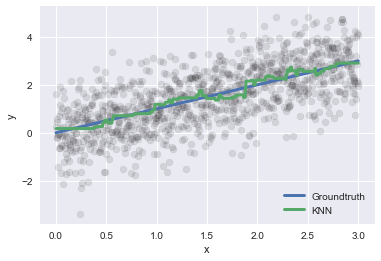

In [265]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

При размере N = 150 и выше регрессионная прямая перестаёт быть визуально отличимой от истинной.
В результате данного эксперимента можно заметить, что ошибка в линейной регрессии на первых N случайных элементах достаточно высока, но по мере увеличения количества попыток обучения снижается и затем остается сравнительно малой. Регрессионная прямая визуально не отличима от истинной.
Ошибка в KNN при n_neighbors = 3 значительна и с увеличением N не уменьшается. Регрессионная прямая плохо приближена к истинной. При n_neighbors = 10 ошибка с увеличением N уменьшается, но затем по мере увеличения N не изменяется, а даже немного растёт. Регрессионная кривая лучше приближена к истинной, чем в случае с 3 соседями, но намного хуже чем в линейной регрессии.

#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        pp.PolynomialFeatures(degree=d_new)
        X_new = pp.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [339]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [340]:
err_1 = []
LRs_1 = []
for N in N_grid:
    LR = lm.LinearRegression()
    rand = np.random.randint(0,990, size= N)
    LR.fit(X[rand],y[rand])
    y_pred = LR.predict(X)
    err_1.append(mean_squared_error(y_pred,y_gt))
    LRs_1.append(LR)
      
import sklearn.preprocessing as pp
    
err_2 = []
LRs_2 = []
poly = pp.PolynomialFeatures(2)
X_new_2 = poly.fit_transform(X)
for N in N_grid:
    LR = lm.LinearRegression()
    rand = np.random.randint(0,990, size= N)
    LR.fit(X_new_2[rand],y[rand])
    y_pred = LR.predict(X_new_2)
    err_2.append(mean_squared_error(y_pred,y_gt))
    LRs_2.append(LR)

err_3 = []
LRs_3 = []
poly = pp.PolynomialFeatures(degree=5)
X_new_3 = poly.fit_transform(X)
for N in N_grid:
    LR = lm.LinearRegression()
    rand = np.random.randint(0,990, size= N)
    LR.fit(X_new_3[rand],y[rand])
    y_pred = LR.predict(X_new_3)
    err_3.append(mean_squared_error(y_pred,y_gt))
    LRs_3.append(LR)


Код для построения всех графиков:

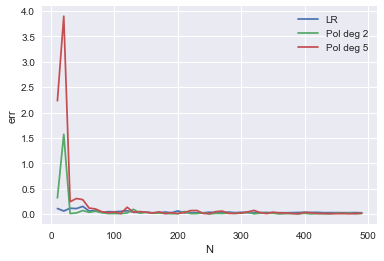

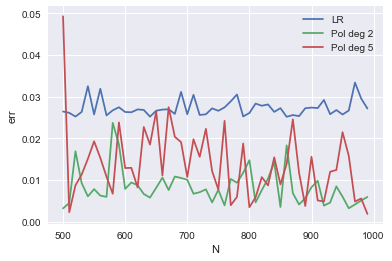

In [341]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

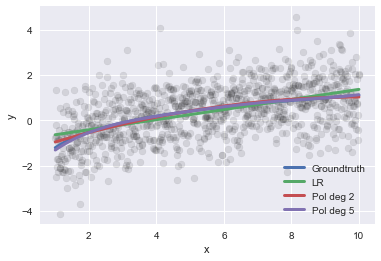

In [269]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

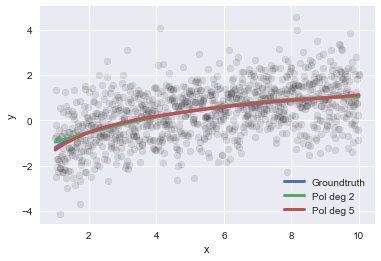

In [270]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

При увеличении степени полинома средняя квадратичная ошибка должна уменьшаться, но при степени 5 она выше, чем при степени 2. Это значит, что алгоритм переобучается. Оптимальный выбор- 2 степень полинома.

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [271]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [272]:
    LR = lm.LinearRegression()
    LR.fit(X,y)
    y_pred_LR = LR.predict(X)
print("MSE = ", mean_squared_error(y_pred_LR,y_gt))
    
    Ridge = lm.Ridge()
    Ridge.fit(X,y)
    y_pred_Ridge = Ridge.predict(X)
print("MSE Ridge = ", mean_squared_error(y_pred_Ridge,y_gt))

MSE =  0.00463984466248
MSE Ridge =  0.00500268618516


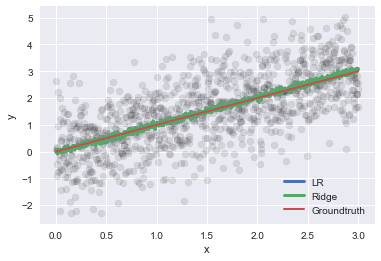

In [273]:
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

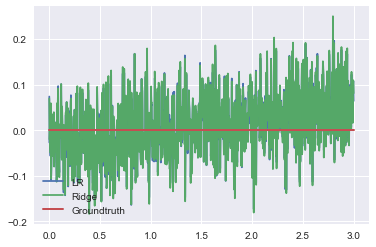

In [274]:
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [275]:
print(np.sum((y_pred_LR - y_gt)**2))
print(np.sum((y_pred_Ridge - y_gt)**2))

4.63984466248
5.00268618516


In [276]:
print(LR.coef_)
print(Ridge.coef_)

[[ 0.54349571  0.06566941  0.11888843]]
[[ 0.39530521  0.13686709  0.12074744]]


Невозможно определить какая регрессия лучше, так как данные генерируются случайно и коэффициенты каждый раз отличаются (то лучше Ridge, то линейная регрессия). MSE у двух регрессий так же постоянно разные и нельзя сказать у какой меньше. Для получения лучшего качество на Ridge регрессии нужно настроить параметр альфа.

#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [277]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [278]:
Ridge = lm.Ridge()
Ridge.fit(X,y)
y_pred_Ridge = Ridge.predict(X)
    
Lasso = lm.Lasso()
Lasso.fit(X, y)
y_pred_Lasso = Lasso.predict(X)

In [279]:
print(Lasso.coef_)
print(Ridge.coef_)

[ 0.          0.          0.17956663  0.0492091 ]
[[ 0.57648265  1.0150514   0.21361796  0.00351199]]


Метод Lasso преодолевает недостаток Ridge регрессии, не просто "наказывая" высокие значения коэффициентов бетта, а приравнивая их к 0, если они не имеют значения. Таким образом, итоговая выборка может быть меньше. Это преимущество, потому что мы выкинем ненужные признаки. Из наших 4 признаков мы выкинули 2 (наверное, потому что они линейно зависимы)

## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [324]:
import pandas as pd

In [325]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data", 
na_values="?", header=None) 
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [326]:
data = data.iloc[:,5:]

#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

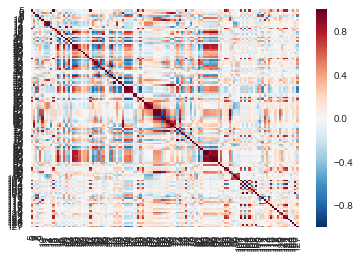

In [327]:
import seaborn as sns
correlation = data.corr(method = 'pearson')
sns.heatmap(correlation)

Коррелирующие признаки будут плохо влиять на обучение линейной регрессии, так как присутствие в данных неинформативных (а если один признак сильно коррелирует с другим, то один из них можно выкинуть) признаков приводит к снижению точности многих моделей, особенно линейных.

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

49 55


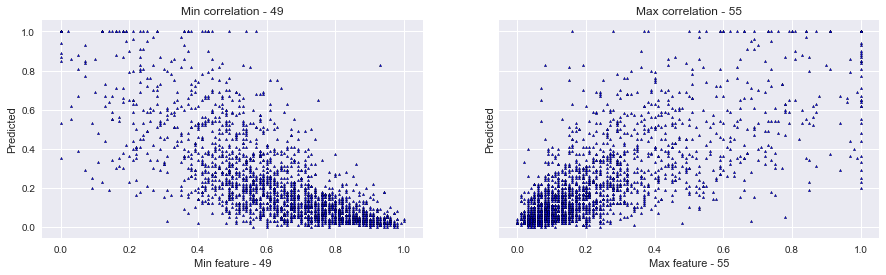

In [328]:
temp = data.corr().iloc[:-1,-1]
pr_min = np.argmin(temp)
pr_max = np.argmax(temp)
pr_min
print(pr_min, pr_max)
fig, axis = plt.subplots(1, 2, figsize = (15,4), sharey=True, sharex = True)
axis[0].scatter(data[pr_min], data[127], c = 'blue',s=6, edgecolor = 'black', marker = '^')
axis[1].scatter(data[pr_max],data[127],c='blue',s=6, edgecolor='black',  marker = '^')

axis[0].set_title('Min correlation - ' + str(pr_min))
axis[1].set_title('Max correlation - ' + str(pr_max))

axis[0].set_xlabel('Min feature - ' + str(pr_min))
axis[1].set_xlabel('Max feature - ' + str(pr_max))
for i in range(2):
    axis[i].set_ylabel('Predicted')

#### 3. Постройте гистограмму распределения предсказываемого значения.

(array([ 122.,  196.,  229.,  132.,  183.,  139.,   75.,   73.,  110.,
          56.,   71.,   68.,   35.,   53.,   39.,   27.,   36.,   13.,
          29.,   19.,   33.,   30.,   19.,   25.,   13.,   11.,   22.,
          20.,    6.,    6.,   10.,    4.,   12.,    9.,    9.,    3.,
           5.,    5.,    3.,   44.]),
 array([ 0.   ,  0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,
         0.2  ,  0.225,  0.25 ,  0.275,  0.3  ,  0.325,  0.35 ,  0.375,
         0.4  ,  0.425,  0.45 ,  0.475,  0.5  ,  0.525,  0.55 ,  0.575,
         0.6  ,  0.625,  0.65 ,  0.675,  0.7  ,  0.725,  0.75 ,  0.775,
         0.8  ,  0.825,  0.85 ,  0.875,  0.9  ,  0.925,  0.95 ,  0.975,  1.   ]),
 <a list of 40 Patch objects>)

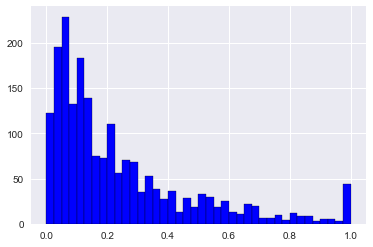

In [329]:
plt.hist(data[127], 40,  color = 'blue',edgecolor = 'black')

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [330]:
data = data.fillna(data.mean())
data.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.060000,0.040000,0.900000,0.500000,0.32,0.140000,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.163103,0.076708,0.698589,0.440439,0.00,0.195078,0.03


Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество:

In [331]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [332]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [333]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [334]:
from sklearn.metrics import mean_squared_error
LR = lm.LinearRegression()
LR.fit(X_train_new, y_train_new)
y_predict = LR.predict(X_test)
error = mean_squared_error(y_predict, y_test)
error

0.018700800102538495

#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [335]:
Ridge = lm.Ridge()
Lasso = lm.Lasso()
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': [15,10,5,2,3,4,0.4,0.03, 0.01, 0.0025, 5, 0.21, 0.5, 0.048, 0.002, 0.0001]}
gsR = GridSearchCV(Ridge, parameters, scoring='neg_mean_squared_error')
gsL = GridSearchCV(Lasso,parameters, scoring='neg_mean_squared_error')
gsR.fit(X_train_new, y_train_new)
gsL.fit(X_train_new, y_train_new)
print('Ridge - ' + str(gsR.best_estimator_.alpha))
print('Lasso - ' +str(gsL.best_estimator_.alpha))

Ridge - 10
Lasso - 0.0001


Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [336]:
Ridge = lm.Ridge(alpha = gsR.best_estimator_.alpha)
Ridge.fit(X_train_new, y_train_new)
y_predictRidge = Ridge.predict(X_test)
err_Ridge = mean_squared_error(y_predictRidge, y_test)
print('Ridge - ' + str(err_Ridge))

Lasso = lm.Lasso(alpha = gsL.best_estimator_.alpha)
Lasso.fit(X_train_new, y_train_new)
y_predictLasso = Lasso.predict(X_test)
err_Lasso = mean_squared_error(y_predictLasso, y_test)
print('Lasso - ' + str(err_Lasso))

Ridge - 0.0178518444258
Lasso - 0.017447060323


Лассо зануляет незначимые признаки. Это значит то, что у нас есть неинформативные данные, которые как раз и зануляет Lasso

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [337]:
newest_x_train = X_train_new[:, abs(Lasso.coef_) != 0]
newest_x_test = X_test.iloc[:, abs(Lasso.coef_) != 0]

Ridge = lm.Ridge(alpha = gsR.best_estimator_.alpha)
Ridge.fit(newest_x_train, y_train_new)
y_predictRidge = Ridge.predict(newest_x_test)
err_Ridge = mean_squared_error(y_predictRidge, y_test)
print('Ridge - ' + str(err_Ridge))

Lasso = lm.Lasso(alpha = gsL.best_estimator_.alpha)
Lasso.fit(newest_x_train, y_train_new)
y_predictLasso = Lasso.predict(newest_x_test)
err_Lasso = mean_squared_error(y_predictLasso, y_test)
print('Lasso - ' + str(err_Lasso))

Ridge - 0.0177840560202
Lasso - 0.0174474796432


Средняя ошибка практически не изменилась. Это значит, что эти признаки неинформативны и их можно убрать.

#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [338]:
from sklearn.neighbors import KNeighborsRegressor
clf= KNeighborsRegressor(n_neighbors=10)
clf.fit(X_train_new, y_train_new)
y_predict = clf.predict(X_test)
err = mean_squared_error(y_predict,y_test)
err

0.021668320783132529

#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [344]:
from sklearn import neighbors
params = dict(metric = ['minkowski'], p = np.arange(1,3,0.1), n_neighbors = np.arange(1,10))
gr = GridSearchCV(neighbors.KNeighborsRegressor(), param_grid = params)
gr.fit(X_train_new, y_train_new)
gr.best_params

С помощью какого алгоритма удалось достичь лучшего качества?

Все алгоритмы дают MSE примерно ~0,2, однако Ridge и Lasso дают качество немного лучше остальных моделей. Ridge и Lasso сравнить между собой трудно, так как в разных попытках они дают разные результаты (ошибка ниже то в одной, то в другой модели)

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

Данный датасет имеет множество переменных для проверки алгоритмов, которые выбирают или изучают веса признаков. Не связанные признаки не были включены, признаки были отобраны таким образом, чтобы была хоть какая-то связь между ними. В датасете помимо основных признаков ещё есть признаки с предсказываемым значением.
Для исследования данного датасеты мы использовали: линейную регрессию, метод ближайших соседей KNN, Ridge и Lasso регрессию. Линейная регрессия дает достаточно низкую ошибку, практически не отличимумю от RIdge и Lasso (и то если им подобрать верные параметры), KNN дает более грубую ошибку.
Признаки в данном датасете не все информативны. Это можно заметить по регрессии Lasso. Наше качество улучшилось на этой регрессии, а это значит, что мы отбросили неинформативные признаки.
Я бы предпочел использовать Lasso регрессию. Она лучше всего борется с неинформативными признаками, не просто уменьшая вес их, а приравнивая их к 0. Это эффективный метод понижения размерности выборки